In [1]:
import os
from pathlib import Path

from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.callbacks as cb
from tensorflow.keras import layers, losses
from tensorflow.keras.layers import LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.python.keras.layers import TimeDistributed

load_dotenv()

True

In [2]:
if Path('./setup.py').exists():
    !pip install -e .
else:
    !pip install -U git+https://github.com/OpheliaMiralles/WindDownscaling_EPFL_UNIBE.git

Obtaining file:///Users/Boubou/Documents/GitHub/WindDownscaling_EPFL_UNIBE
  Attempting uninstall: downscaling
    Found existing installation: downscaling 1.0
    Uninstalling downscaling-1.0:
      Successfully uninstalled downscaling-1.0
  Running setup.py develop for downscaling


In [3]:
from autoencoder.autoencoder import AutoEncoder, WeightedMeanSquaredError

In [4]:
ERA5_PREDICTORS_SURFACE = ('u10', 'v10', 'blh', 'fsr', 'sp', 'sshf',
                               'u100', 'v100')
ERA5_PREDICTORS_Z500 = ('d', 'z', 'u', 'v', 'w', 'vo')
TOPO_PREDICTORS = ('tpi_500', 'ridge_index_norm', 'ridge_index_dir',
                   'we_derivative', 'sn_derivative',
                   'slope', 'aspect')
ALL_INPUTS = ERA5_PREDICTORS_SURFACE + ERA5_PREDICTORS_Z500 + TOPO_PREDICTORS
DATA_ROOT = Path('./data')
ERA5_DATA_FOLDER = DATA_ROOT / 'ERA5'
COSMO1_DATA_FOLDER = DATA_ROOT / 'COSMO1'
DEM_DATA_FILE = DATA_ROOT / 'dem/Switzerland-90m-DEM.tif'
PROCESSED_DATA_FOLDER = DATA_ROOT / 'img_prediction_files'

In [5]:
START_DATE = pd.to_datetime('2016-04-01')
END_DATE = pd.to_datetime('2018-04-01')
nb_batches = len(pd.date_range(START_DATE, END_DATE))  # We want every day we can get
SEQUENCE_LENGTH = 1
IMG_SIZE = 64
BATCH_SIZE = 32
BATCH_WORKERS = 8
OUTPUT_FEATURES = 8

In [6]:
def build_autoencoder():
    x = AutoEncoder(nb_channels_in=len(ALL_INPUTS), nb_channels_out=OUTPUT_FEATURES,
                       time_steps=SEQUENCE_LENGTH, img_size=IMG_SIZE)
    w_u10_v10 = 0.15
    weights = np.array([w_u10_v10, w_u10_v10] + [(1 - 2 * w_u10_v10) / (len(ALL_INPUTS) - 2)] * (len(ALL_INPUTS) - 2),
                   dtype=np.float32)
    x.compile('adam', loss=WeightedMeanSquaredError(weights))
    return x
autoencoder = build_autoencoder()
autoencoder.encoder.summary()
autoencoder.decoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 1, 64, 64, 168)    31920     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1, 64, 64, 168)    672       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 64, 64, 42)     63546     
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 64, 64, 42)     168       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 64, 64, 12)     4548      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 1, 64, 64, 12)     48        
_________________________________________________________________
time_distributed_6 (TimeDist (None, 1, 64, 64, 8)      872 

In [7]:
def show(image, dims=2, legends=None):
    fig = plt.figure(figsize=(10, 10))

    for i in range(dims):
        label = legends[i] if legends is not None else ''
        plt.subplot(1, dims, i+1)
        plt.imshow(image[0, :, :, i], cmap='jet')
        plt.title(label)
        plt.axis('off')
    plt.show()

In [8]:
from data.download_ERA5 import download_ERA5
download_ERA5(ERA5_DATA_FOLDER, START_DATE, END_DATE)
print('Done')

File 20160401_era5_surface_hourly already exists
File 20160402_era5_surface_hourly already exists
File 20160403_era5_surface_hourly already exists
File 20160404_era5_surface_hourly already exists
File 20160405_era5_surface_hourly already exists
File 20160406_era5_surface_hourly already exists
File 20160407_era5_surface_hourly already exists
File 20160408_era5_surface_hourly already exists
File 20160409_era5_surface_hourly already exists
File 20160410_era5_surface_hourly already exists
File 20160411_era5_surface_hourly already exists
File 20160412_era5_surface_hourly already exists
File 20160413_era5_surface_hourly already exists
File 20160414_era5_surface_hourly already exists
File 20160415_era5_surface_hourly already exists
File 20160416_era5_surface_hourly already exists
File 20160417_era5_surface_hourly already exists
File 20160418_era5_surface_hourly already exists
File 20160419_era5_surface_hourly already exists
File 20160420_era5_surface_hourly already exists
File 20160421_era5_s

In [9]:
username = os.getenv('COSMO_USERNAME')
password = os.getenv('COSMO_PASSWORD')
from data import download_COSMO1
download_COSMO1(username, password, COSMO1_DATA_FOLDER, START_DATE, END_DATE)

Finished downloading COSMO data


In [10]:
from data.data_processing import process_imgs

process_imgs(PROCESSED_DATA_FOLDER, ERA5_DATA_FOLDER, COSMO1_DATA_FOLDER, DEM_DATA_FILE.parent,
             START_DATE, END_DATE, surface_variables_included=ERA5_PREDICTORS_SURFACE,
             z500_variables_included=ERA5_PREDICTORS_Z500, topo_variables_included=TOPO_PREDICTORS)
print('Done')

2021-08-19 14:44:39,161 INFO Loading /Users/Boubou/opt/anaconda3/envs/downscale_dev/lib/python3.9/site-packages/topo_descriptors/config/topo_descriptors.conf.
2021-08-19 14:44:39,161 INFO Loading configuration file: /Users/Boubou/opt/anaconda3/envs/downscale_dev/lib/python3.9/site-packages/topo_descriptors/config/topo_descriptors.conf


Reading DEM data files
Inputs and outputs for date 20160401 have already been processed.
Inputs and outputs for date 20160402 have already been processed.
Inputs and outputs for date 20160403 have already been processed.
Inputs and outputs for date 20160404 have already been processed.
Inputs and outputs for date 20160405 have already been processed.
Inputs and outputs for date 20160406 have already been processed.
Inputs and outputs for date 20160407 have already been processed.
Inputs and outputs for date 20160408 have already been processed.
Inputs and outputs for date 20160409 have already been processed.
Inputs and outputs for date 20160410 have already been processed.
Inputs and outputs for date 20160411 have already been processed.
Inputs and outputs for date 20160412 have already been processed.
Inputs and outputs for date 20160413 have already been processed.
Inputs and outputs for date 20160414 have already been processed.
Inputs and outputs for date 20160415 have already bee

In [11]:
from data.data_generator import BatchGenerator, NaiveDecoder

batch_gen = BatchGenerator(path_to_data=PROCESSED_DATA_FOLDER, decoder=NaiveDecoder(normalize=True),
                       sequence_length=SEQUENCE_LENGTH,
                       patch_length_pixel=IMG_SIZE, batch_size=BATCH_SIZE,
                       input_variables=ALL_INPUTS,
                       start_date=START_DATE, end_date=END_DATE, num_workers=BATCH_WORKERS)
batches = []
with batch_gen as batch:
    for b in range(nb_batches):
        print(f'Creating batch {b+1}/{nb_batches}')
        batches.append(next(batch)[0])
inputs = np.concatenate(batches, axis=0)
print('done')

2021-08-19 14:44:39,974 WARNING multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


Creating batch 1/731
Creating batch 2/731
Creating batch 3/731
Creating batch 4/731
Creating batch 5/731
Creating batch 6/731
Creating batch 7/731
Creating batch 8/731
Creating batch 9/731
Creating batch 10/731
Creating batch 11/731
Creating batch 12/731
Creating batch 13/731
Creating batch 14/731
Creating batch 15/731
Creating batch 16/731
Creating batch 17/731
Creating batch 18/731
Creating batch 19/731
Creating batch 20/731
Creating batch 21/731
Creating batch 22/731
Creating batch 23/731
Creating batch 24/731
Creating batch 25/731
Creating batch 26/731
Creating batch 27/731
Creating batch 28/731
Creating batch 29/731
Creating batch 30/731
Creating batch 31/731
Creating batch 32/731
Creating batch 33/731
Creating batch 34/731
Creating batch 35/731
Creating batch 36/731
Creating batch 37/731
Creating batch 38/731
Creating batch 39/731
Creating batch 40/731
Creating batch 41/731
Creating batch 42/731
Creating batch 43/731
Creating batch 44/731
Creating batch 45/731
Creating batch 46/7

Creating batch 362/731
Creating batch 363/731
Creating batch 364/731
Creating batch 365/731
Creating batch 366/731
Creating batch 367/731
Creating batch 368/731
Creating batch 369/731
Creating batch 370/731
Creating batch 371/731
Creating batch 372/731
Creating batch 373/731
Creating batch 374/731
Creating batch 375/731
Creating batch 376/731
Creating batch 377/731
Creating batch 378/731
Creating batch 379/731
Creating batch 380/731
Creating batch 381/731
Creating batch 382/731
Creating batch 383/731
Creating batch 384/731
Creating batch 385/731
Creating batch 386/731
Creating batch 387/731
Creating batch 388/731
Creating batch 389/731
Creating batch 390/731
Creating batch 391/731
Creating batch 392/731
Creating batch 393/731
Creating batch 394/731
Creating batch 395/731
Creating batch 396/731
Creating batch 397/731
Creating batch 398/731
Creating batch 399/731
Creating batch 400/731
Creating batch 401/731
Creating batch 402/731
Creating batch 403/731
Creating batch 404/731
Creating ba

Creating batch 722/731
Creating batch 723/731
Creating batch 724/731
Creating batch 725/731
Creating batch 726/731
Creating batch 727/731
Creating batch 728/731
Creating batch 729/731
Creating batch 730/731
Creating batch 731/731
done


In [12]:
class ShowCallback(tf.keras.callbacks.Callback):
    def __init__(self, dims):
        self.dims = dims
    
    def on_epoch_end(self, epoch, logs):
        show(self.model(inputs[:1])[0], dims=self.dims)

In [13]:
checkpoint_path_weights = Path('./checkpoints/autoencoder/weights.ckpt')
checkpoint_path_weights.parent.mkdir(exist_ok=True, parents=True)
log_path = Path('./logs/autoencoder')
if log_path.exists():
    log_path_str = str(log_path)
    !rm -rf {log_path_str}

In [14]:
%load_ext tensorboard
%tensorboard --logdir=logs/autoencoder

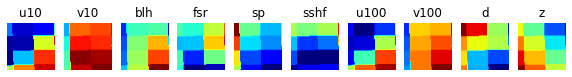

In [15]:
show(inputs[0], 10, batch_gen._bg.input_variables)

Epoch 1/500
32/32 [==============================] - 117s 4s/step - loss: 0.9904 - val_loss: 0.8878


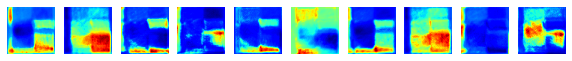

Epoch 2/500
32/32 [==============================] - 54s 2s/step - loss: 0.8367 - val_loss: 0.8501


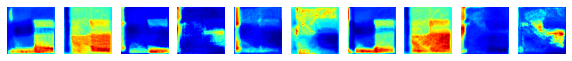

Epoch 3/500
32/32 [==============================] - 54s 2s/step - loss: 0.7967 - val_loss: 0.8218


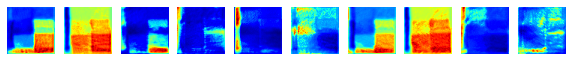

Epoch 4/500
32/32 [==============================] - 55s 2s/step - loss: 0.7632 - val_loss: 0.7978


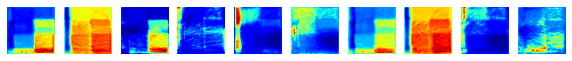

Epoch 5/500
32/32 [==============================] - 59s 2s/step - loss: 0.7314 - val_loss: 0.7760


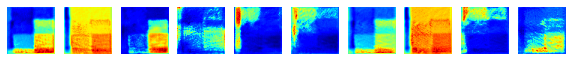

Epoch 6/500
32/32 [==============================] - 67s 2s/step - loss: 0.7038 - val_loss: 0.7575


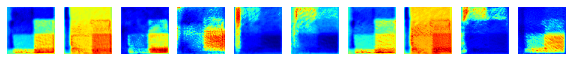

Epoch 7/500
32/32 [==============================] - 58s 2s/step - loss: 0.6852 - val_loss: 0.7417


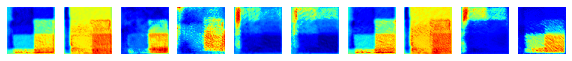

Epoch 8/500
32/32 [==============================] - 58s 2s/step - loss: 0.6698 - val_loss: 0.7257


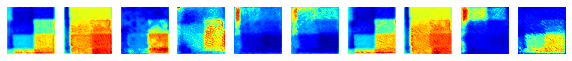

Epoch 9/500
32/32 [==============================] - 68s 2s/step - loss: 0.6603 - val_loss: 0.7049


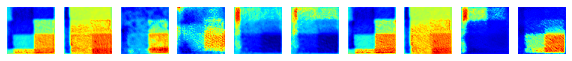

Epoch 10/500
32/32 [==============================] - 78s 2s/step - loss: 0.6525 - val_loss: 0.6912


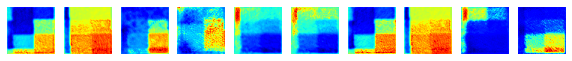

Epoch 11/500
32/32 [==============================] - 78s 2s/step - loss: 0.6458 - val_loss: 0.6743


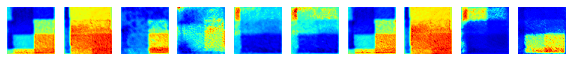

Epoch 12/500
32/32 [==============================] - 87s 3s/step - loss: 0.6375 - val_loss: 0.6567


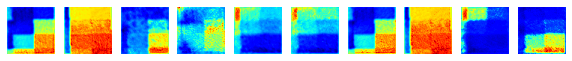

Epoch 13/500
32/32 [==============================] - 84s 3s/step - loss: 0.6308 - val_loss: 0.6453


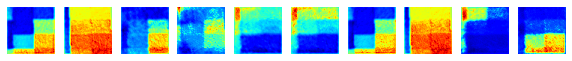

Epoch 14/500
32/32 [==============================] - 83s 3s/step - loss: 0.6258 - val_loss: 0.6460


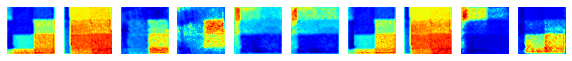

Epoch 15/500
32/32 [==============================] - 84s 3s/step - loss: 0.6177 - val_loss: 0.6472


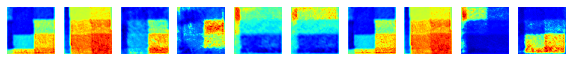

Epoch 16/500
32/32 [==============================] - 79s 3s/step - loss: 0.6105 - val_loss: 0.6472


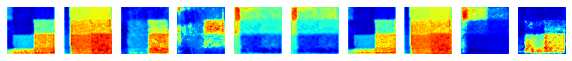

Epoch 17/500
32/32 [==============================] - 83s 3s/step - loss: 0.6069 - val_loss: 0.6326


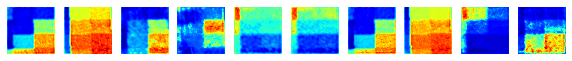

Epoch 18/500
32/32 [==============================] - 53s 2s/step - loss: 0.6047 - val_loss: 0.6226


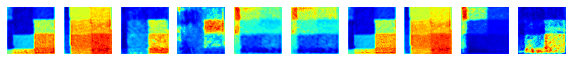

Epoch 19/500
32/32 [==============================] - 53s 2s/step - loss: 0.5956 - val_loss: 0.6191


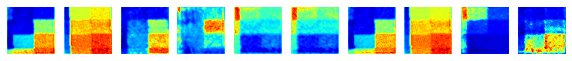

Epoch 20/500
32/32 [==============================] - 58s 2s/step - loss: 0.5948 - val_loss: 0.6140


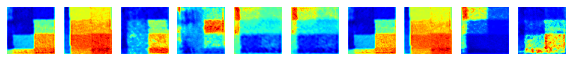

Epoch 21/500
32/32 [==============================] - 59s 2s/step - loss: 0.5924 - val_loss: 0.6105


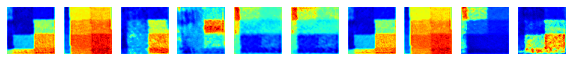

Epoch 22/500
32/32 [==============================] - 58s 2s/step - loss: 0.5872 - val_loss: 0.6058


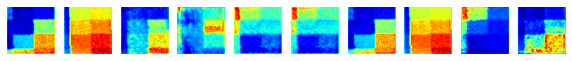

Epoch 23/500
32/32 [==============================] - 56s 2s/step - loss: 0.5825 - val_loss: 0.6012


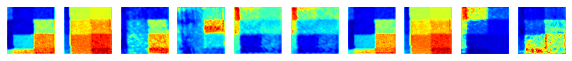

Epoch 24/500
32/32 [==============================] - 60s 2s/step - loss: 0.5847 - val_loss: 0.5950


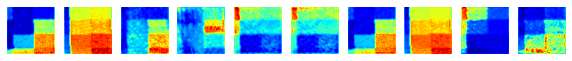

Epoch 25/500
32/32 [==============================] - 57s 2s/step - loss: 0.5794 - val_loss: 0.5882


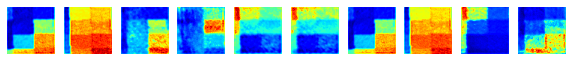

Epoch 26/500
32/32 [==============================] - 61s 2s/step - loss: 0.5786 - val_loss: 0.5902


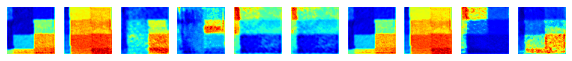

Epoch 27/500
32/32 [==============================] - 64s 2s/step - loss: 0.5729 - val_loss: 0.5904


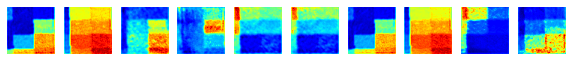

Epoch 28/500
32/32 [==============================] - 59s 2s/step - loss: 0.5691 - val_loss: 0.5883


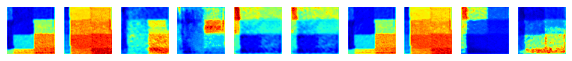

Epoch 29/500
32/32 [==============================] - 65s 2s/step - loss: 0.5687 - val_loss: 0.5861


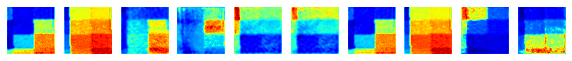

Epoch 30/500
32/32 [==============================] - 79s 3s/step - loss: 0.5696 - val_loss: 0.5914


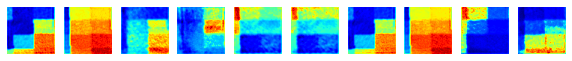

Epoch 31/500
32/32 [==============================] - 67s 2s/step - loss: 0.5685 - val_loss: 0.5793


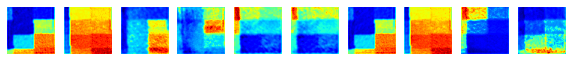

Epoch 32/500
32/32 [==============================] - 72s 2s/step - loss: 0.5642 - val_loss: 0.5799


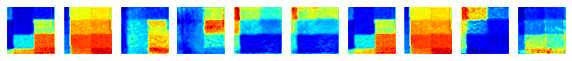

Epoch 33/500
32/32 [==============================] - 59s 2s/step - loss: 0.5638 - val_loss: 0.5828


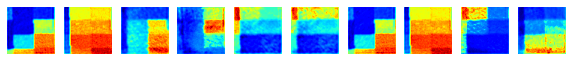

Epoch 34/500
30/32 [===========================>..] - ETA: 1s - loss: 0.5614

In [ ]:
callbacks = [
        cb.TensorBoard(log_path, write_images=True, histogram_freq=1, profile_batch=(2, 4)),
        cb.ProgbarLogger('steps'),
        #cb.EarlyStopping(min_delta=2e-3, patience=10),
        cb.TerminateOnNaN(),
        cb.ModelCheckpoint(checkpoint_path_weights, monitor='loss', save_best_only=True, save_weights_only=True),
        ShowCallback(10),
    ]
history = autoencoder.fit(inputs, inputs, batch_size=BATCH_SIZE, epochs=500, steps_per_epoch=32,
                          callbacks=callbacks, validation_split=0.25)

In [ ]:
best_weights = build_autoencoder()
best_weights.load_weights(checkpoint_path_weights)
best_weights.evaluate(inputs, inputs)